In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score

Загрузим данные, используя определенный сэмпл, так как модель на всем обьеме данных будет слишком долго тренироваться.

In [2]:
# Function to load a sample of data
def load_sampled_data(sample_percent):
    print('Loading data...')
    train = pd.read_csv(f'train.csv', dtype={
        'msno' : 'category',
        'song_id' : 'category',
        'source_system_tab' : 'category',
        'source_screen_name' : 'category',
        'source_type' : 'category',
        'target' : np.uint8
    }).sample(frac=sample_percent, random_state=42)

    
    test = pd.read_csv(f'test.csv', dtype={
        'msno' : 'category',
        'song_id' : 'category',
        'source_system_tab' : 'category',
        'source_screen_name' : 'category',
        'source_type' : 'category'
    })
    
    songs = pd.read_csv(f'songs.csv', dtype={
        'song_id' : 'category',
        'artist_name' : 'category',
        'composer' : 'category',
        'lyricist' : 'category',
        'genre_ids' : 'category',
        'language' : 'category'
    })
    
    members = pd.read_csv(f'members.csv', dtype={
        'msno' : 'category',
        'city' : 'category',
        'bd' : np.uint8,
        'gender' : 'category',
        'registered_via' : 'category'
    })
    
    songs_extra = pd.read_csv(f'song_extra_info.csv')
    
    return train, test, songs, members, songs_extra

train, test, songs, members, songs_extra = load_sampled_data(0.002)

Loading data...


Проведем Exploratory Data Analysis,

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting aesthetic parameters for seaborn
sns.set(style="whitegrid")

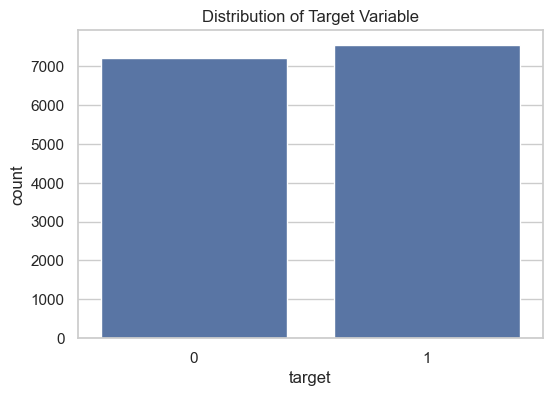

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=train)
plt.title('Distribution of Target Variable')
plt.show()

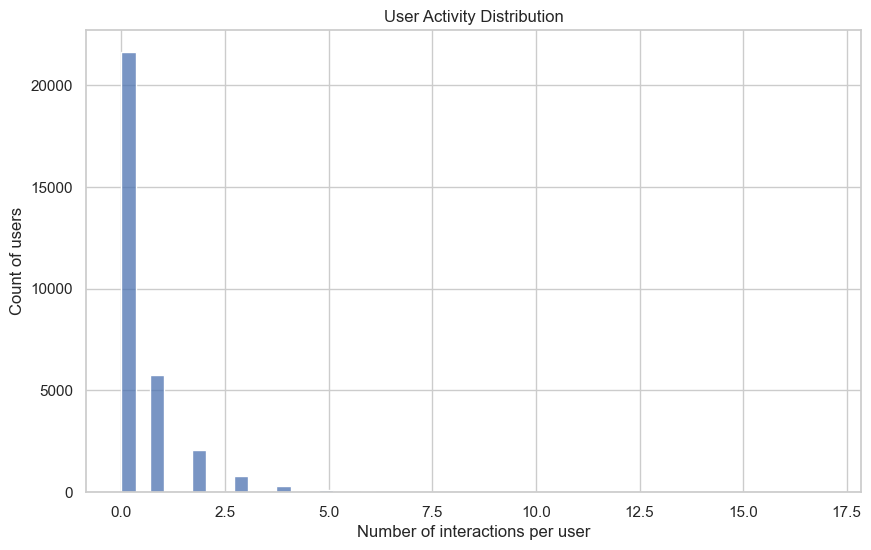

In [5]:
# Count number of entries per user
user_activity = train['msno'].value_counts()

plt.figure(figsize=(10,6))
sns.histplot(user_activity, bins=50, kde=False)
plt.title('User Activity Distribution')
plt.xlabel('Number of interactions per user')
plt.ylabel('Count of users')
plt.show()

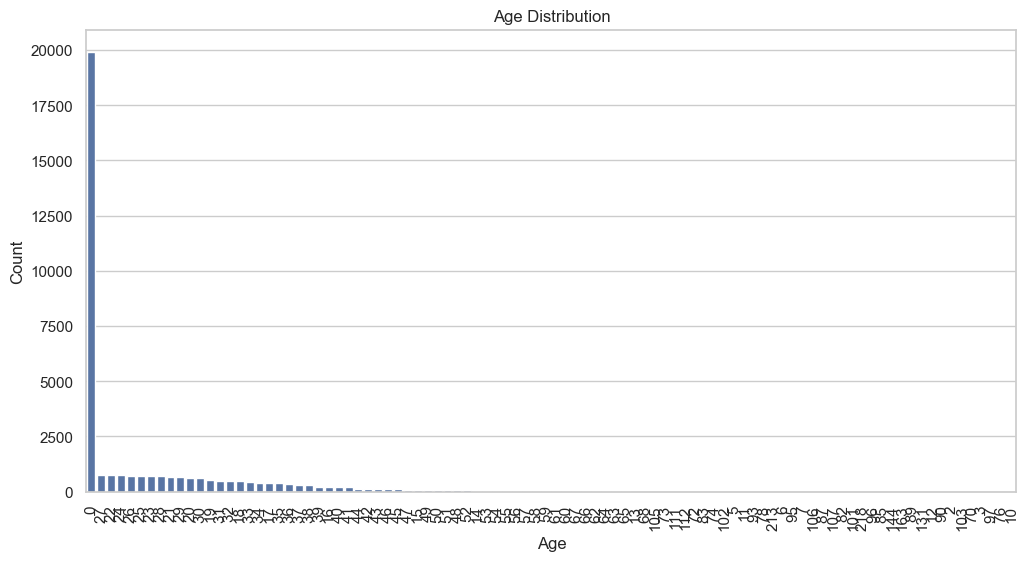

In [6]:
plt.figure(figsize=(12, 6))
sns.countplot(x='bd', data=members, order=members['bd'].value_counts().index)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

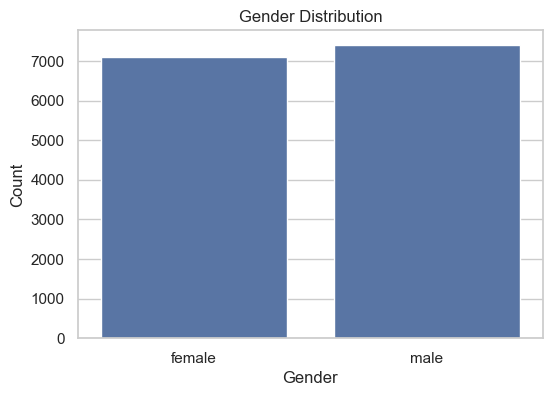

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=members)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

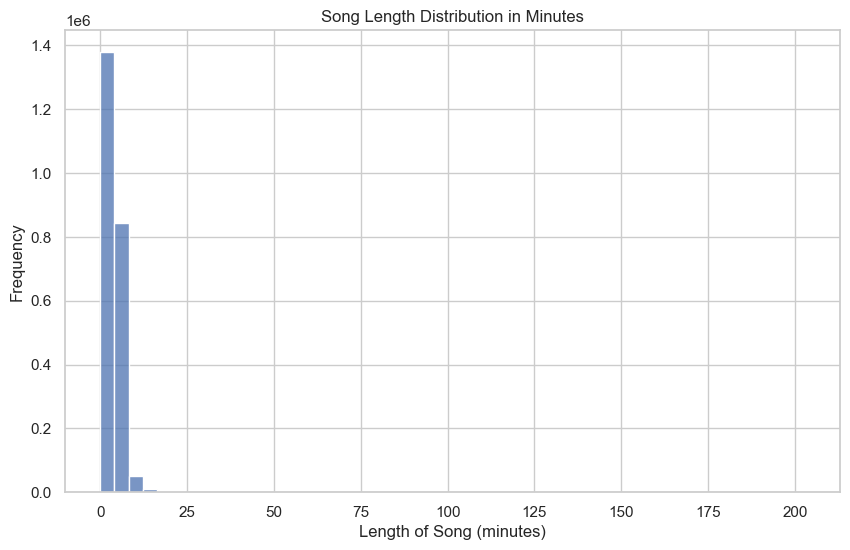

In [8]:
# Convert song length from ms to minutes for better interpretation
songs['song_length_min'] = songs['song_length'] / 60000

plt.figure(figsize=(10,6))
sns.histplot(songs['song_length_min'], bins=50, kde=False)
plt.title('Song Length Distribution in Minutes')
plt.xlabel('Length of Song (minutes)')
plt.ylabel('Frequency')
plt.show()

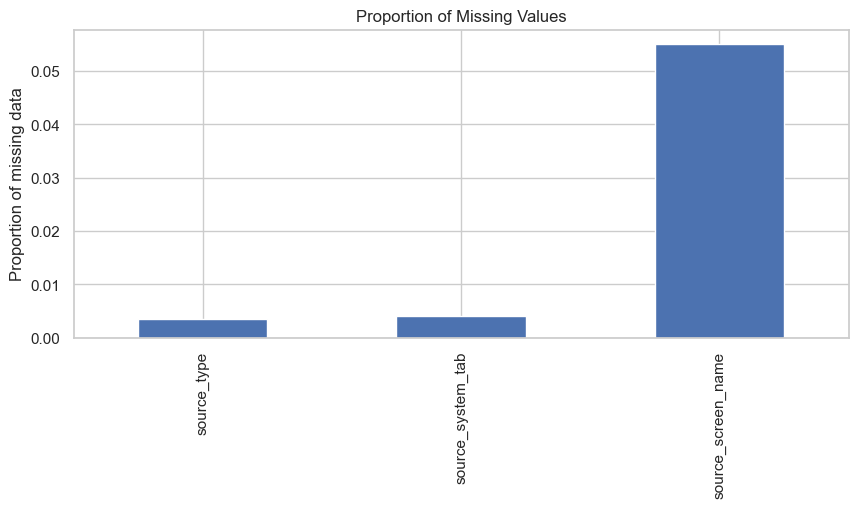

In [9]:
missing_values = train.isnull().sum() / len(train)
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)

plt.figure(figsize=(10, 4))
missing_values.plot.bar()
plt.title('Proportion of Missing Values')
plt.ylabel('Proportion of missing data')
plt.show()

Соединим таблицы, удалив и обработав некоторые колонны.

In [10]:
# Merging datasets
def merge_data(train, test, songs, members, songs_extra):
    print('Data preprocessing and feature engineering...')
    song_cols = ['song_id', 'artist_name', 'genre_ids', 'song_length', 'language']
    train = train.merge(songs[song_cols], on='song_id', how='left')
    test = test.merge(songs[song_cols], on='song_id', how='left')
    
    # Converting dates into usable features
    members['registration_year'] = members['registration_init_time'].apply(lambda x: int(str(x)[:4]))
    members['registration_month'] = members['registration_init_time'].apply(lambda x: int(str(x)[4:6]))
    members['registration_date'] = members['registration_init_time'].apply(lambda x: int(str(x)[6:8]))
    
    members['expiration_year'] = members['expiration_date'].apply(lambda x: int(str(x)[:4]))
    members['expiration_month'] = members['expiration_date'].apply(lambda x: int(str(x)[4:6]))
    members['expiration_day'] = members['expiration_date'].apply(lambda x: int(str(x)[6:8]))
    members.drop(['registration_init_time', 'expiration_date'], axis=1, inplace=True)
    
    # Parsing ISRC codes
    def isrc_to_year(isrc):
        if type(isrc) == str and len(isrc) > 7:
            year = int(isrc[5:7])
            return 1900 + year if year > 17 else 2000 + year
        return np.nan
    
    songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
    songs_extra.drop(['isrc'], axis=1, inplace=True)
    
    train = train.merge(members, on='msno', how='left')
    test = test.merge(members, on='msno', how='left')
    train = train.merge(songs_extra, on='song_id', how='left')
    test = test.merge(songs_extra, on='song_id', how='left')
    return train, test

Сделаем train/test split.

In [11]:
train, test = merge_data(train, test, songs, members, songs_extra)

# Cleanup to free memory
del members, songs, songs_extra
gc.collect()

Data preprocessing and feature engineering...


3165

In [12]:
# Ensure categorical data are properly typed
for col in train.columns:
    if train[col].dtype == 'object':
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')

Натренируем LightGBM модель на наших данных.

In [13]:
# Splitting data for local validation
X_train, X_valid, y_train, y_valid = train_test_split(
    train.drop('target', axis=1), train['target'], test_size=0.25, random_state=42)

# Creating LightGBM datasets
d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_valid, label=y_valid, reference=d_train)

# Training a LightGBM model with early stopping
params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.2,
    'max_depth': 8,
    'num_leaves': 64,
    'verbosity': 0 
}

In [14]:
num_boost_round = 1000

In [15]:
model = lgb.train(params,
                  d_train,
                  num_boost_round=num_boost_round,
                  valid_sets=[d_train, d_valid],
                  callbacks=[lgb.early_stopping(stopping_rounds=50),
                             lgb.log_evaluation(50)])

print("Model training complete.")

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

In [16]:
y_pred = model.predict(X_valid)
print(y_pred)

[0.20965159 0.2150837  0.43510637 ... 0.74319317 0.6422833  0.41587595]


In [17]:
test

,id,msno,song_id,source_system_tab,source_screen_name,source_type,artist_name,genre_ids,song_length,language,...,gender,registered_via,registration_year,registration_month,registration_date,expiration_year,expiration_month,expiration_day,name,song_year
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,梁文音 (Rachel Liang),458,224130.0,3.0,...,NaN,7,2016,2,19,2017,9,18,愛其實很殘忍,2014.0
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library,林俊傑 (JJ Lin),465,320470.0,3.0,...,NaN,7,2016,2,19,2017,9,18,她說,2010.0
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist,Yu Takahashi (高橋優),2022,315899.0,17.0,...,NaN,4,2016,11,17,2016,11,24,subarashiki nichijo,2010.0
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio,U2,465,285210.0,52.0,...,male,9,2007,7,25,2017,4,30,Hold Me| Thrill Me| Kiss Me| Kill Me,2002.0
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio,Yoga Mr Sound,873,197590.0,-1.0,...,male,9,2007,7,25,2017,4,30,Om Yoga,2011.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2556785,2556785,XmA/cIkXJ8jZUfsUc4bBfJVWMMqmylnPW0WVkg/iz0s=,wJoWzZd7AL+qX9xZWZwRTzGRYg0Lxcl5Pe+9n5hZgAQ=,discover,Online playlist more,online-playlist,The Chainsmokers & Coldplay,1609,247640.0,52.0,...,female,9,2010,11,26,2017,9,21,Something Just Like This,2017.0
2556786,2556786,jvbujcxCExG0CrPShsEmZ6pePcHuRqru2OLEUw85iGk=,KCJ8BlSfRQRgB7EVuzFvg52AhR8m2fT032MzN5ewbEI=,discover,NaN,online-playlist,郭美美 (Jocie Guo),458,197067.0,3.0,...,male,9,2014,5,6,2017,9,12,一百種孤獨的理由,2016.0
2556787,2556787,jvbujcxCExG0CrPShsEmZ6pePcHuRqru2OLEUw85iGk=,ySDsKJSnhFMESzC9mBhY0hnFEEBWDYx0FOMNcYDLb/A=,discover,NaN,online-playlist,問樂團 (Guess What),458,212950.0,3.0,...,male,9,2014,5,6,2017,9,12,愛不需要裝乖 / Somewhere I Belong,2016.0
2556788,2556788,jvbujcxCExG0CrPShsEmZ6pePcHuRqru2OLEUw85iGk=,WXH8kL8e+0H2jY+s2Y6FpHyyHdaMYV3b6yfDa3FAt9U=,discover,NaN,online-playlist,陳冠宇 (Kaiel Chen),465,164414.0,3.0,...,male,9,2014,5,6,2017,9,12,陳冠宇 (Kuan Yu Chen),2017.0


In [18]:
train

,msno,song_id,source_system_tab,source_screen_name,source_type,target,artist_name,genre_ids,song_length,language,...,gender,registered_via,registration_year,registration_month,registration_date,expiration_year,expiration_month,expiration_day,name,song_year
0,RGAe8+3OzXCgYYw4LkvHHfGHPW48eT57SO9tCDqF6wU=,XcLZ7BJjc6gG5RPsg7Pb5W04mvlz6jyWErLKofUvFis=,search,Search,song,0,S.H. Project,465,215875,52.0,...,NaN,7,2014,1,24,2017,10,6,Bad Girl Good Girl,2014.0
1,PQfNQQon0CwOLghOAyztQYVw6yJTVgmFpJ650q/UF1s=,9t9+DPdDvWrge1ZOUlcJvLmOfnpa4NtNEVY0rBc/91I=,discover,NaN,top-hits-for-artist,1,梁靜茹 (Fish Leong),465,285779,3.0,...,female,3,2014,11,2,2017,6,17,可惜不是你,2005.0
2,cd9R76nchcG1F1oyKMVN9bXXwRssofcYVckWhIWTSrY=,LAbM25XeS2X4K+HcY802+4tu3VyXbwse7mzIEOorPJY=,radio,Radio,radio,0,Victoria Beckham,465,232060,52.0,...,female,9,2006,3,10,2017,9,24,In Your Dreams,2001.0
3,KFznvngc8H65XDu5Y1ZgitCu5DWeOKpgtVkNYw0qlq8=,3xhSUFUYmiaYUUK6gzDE0vkhxV4nPnpyZL4Z+nzU7/8=,my library,Local playlist more,local-playlist,0,Lucia,359,250462,31.0,...,female,9,2007,9,28,2017,9,30,noir 느와르,1935.0
4,phnWUuC1a4M2RO/6He3Wb8Ji3Ex6QV5AQ2KCGlqpIG8=,+ZXjijLJdny/t5JIuFm4xIlM+bRYKIkaHGDcfDSKfH8=,discover,Artist more,top-hits-for-artist,1,孫子涵 (Niko Sun),465,231026,3.0,...,NaN,9,2015,3,8,2017,9,8,別對我說沒有未來,2015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14750,smpmdFJG23bvY+XiJII4LC7dGvKiybVmHy2gSaVTWxg=,d7kHi7RZXVVWWzh/cZEDYTWG5wfNuJgypRrT1dIgK+E=,my library,Local playlist more,local-playlist,0,aMEI (張惠妹),465,210024,3.0,...,male,7,2012,1,6,2017,10,5,狗,2014.0
14751,Y27j8MWTeyB8WoXA6JohNOhjjaq+e+Mw54utu++uV6g=,a0VQYgdc3c16QYXHxZdR+2JQkmmQQSYWUxDNNJmpYfA=,discover,Discover Genre,album,0,Leona Lewis,465,239709,52.0,...,NaN,7,2014,3,20,2017,9,19,One More Sleep,2013.0
14752,v8oxn7IS9+RRn06MYQmcuJZXFEcvzxBt+GXCgyVQLD8=,0J2MM7SfXD1MR/A/fv+20HNXJPoLtIdGfauVTMU6C6w=,my library,Local playlist more,local-playlist,0,五月天 (Mayday),458,306528,3.0,...,NaN,7,2010,12,9,2017,9,9,終於結束的起點 (Beginning of the End),2016.0
14753,vVPYzaK8XSBdO2GLhe8e+YKOUKfc88Zwu7LmWvVSl5w=,p6vR55B6kN6DL6mkWo3Ndkzd1KEbmr38ndt04bYuzXo=,discover,Online playlist more,online-playlist,1,Various Artists,921,196571,31.0,...,female,9,2004,12,28,2017,9,30,For You,2016.0


In [19]:
y_pred_valid = model.predict(X_valid)

# Calculate NDCG@20
def calculate_ndcg(y_true, y_scores, k=None):
    y_true = np.asarray([y_true])
    y_scores = np.asarray([y_scores])
    if k is not None:
        ndcg = ndcg_score(y_true, y_scores, k=k)
    else:
        ndcg = ndcg_score(y_true, y_scores)
    return ndcg

# Calculate NDCG@20 for the validation set
ndcg_20 = calculate_ndcg(y_valid, y_pred_valid, k=20)
ndcg = calculate_ndcg(y_valid, y_pred_valid)

print(f'NDCG@20 for the validation set: {ndcg_20}')
print(f'NDCG for the validation set: {ndcg}')

NDCG@20 for the validation set: 0.8194597794497122
NDCG for the validation set: 0.9372763001310949


Наша модель показала неплохие результаты на валидационной выборке.